# Import

In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model,plot_prediction_examples
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from obspy.signal.trigger import recursive_sta_lta, trigger_onset
from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [81]:
def lteq(a, b):
    """return a<=b"""
    return (a < b) | (abs(a - b) < 1e-12)  # parentheses are important!!!


print(lteq(10, 20))
print(lteq(np.array([10.0, 20.0]), 20.0))

True
[ True  True]


In [2]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]

# Load data

In [3]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

# print(len(dataset))

Preloading waveforms: 100%|██████████| 35120/35120 [00:46<00:00, 754.59it/s] 


In [4]:
data_eq = dataset.filter(dataset["source_type"] != "noise", inplace=False).test()
np.all((data_eq["split"] == "test").values)

True

In [5]:
data_eq_lp = data_eq.filter(
    (data_eq.metadata["source_type"] == "lp"),
    inplace=False,
)
data_eq_rg = data_eq.filter(
    (data_eq.metadata["source_type"] != "lp"),
    inplace=False,
)

In [6]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 35120/35120 [00:07<00:00, 4719.12it/s]


In [7]:
data_eq_ENZ = dataset_ENZ.filter(
    dataset_ENZ["source_type"] != "noise", inplace=False
).test()
np.all((data_eq_ENZ["split"] == "test").values)

True

In [8]:
data_eq_ENZ_lp = data_eq_ENZ.filter(
    (data_eq_ENZ.metadata["source_type"] == "lp"),
    inplace=False,
)
data_eq_ENZ_rg = data_eq_ENZ.filter(
    (data_eq_ENZ.metadata["source_type"] != "lp"),
    inplace=False,
)

In [9]:
dataset_full = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
data_full_eq = dataset_full.filter(
    dataset_full["source_type"] != "noise", inplace=False
)

# Load models

In [10]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [11]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_eqt2.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_eqt2.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_eqt2.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

['Detection', 'P', 'S']
['Detection', 'P', 'S']
NPS
std
std
std
cuda:0
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


# Figure saving path

In [12]:
root_save_path = Path("./")
try:
    root_save_path.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{root_save_path} exists")

. exists


# Frequency index

In [10]:
freq_indices = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
source_ids = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_id"].to_numpy()

# lp and vt
lp_metadata = data_eq.metadata[data_eq.metadata["source_type"] == "lp"]
rg_metadata = data_eq.metadata[data_eq.metadata["source_type"] != "lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# frequency indexes of lp events and vt events
freq_indices_lp = lp_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
freq_indices_rg = rg_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

15078
15057


In [11]:
# frequency index for each trace
trace_freq_indices = data_eq.metadata["trace_frequency_index"]
trace_freq_indices_lp = lp_metadata["trace_frequency_index"]
trace_freq_indices_rg = rg_metadata["trace_frequency_index"]

In [12]:
print(f"Total {len(freq_indices)}")
print(f"LP: {len(freq_indices_lp)}")
print(f"VT: {len(freq_indices_rg)}")

# validate
print(len(freq_indices_rg) + len(freq_indices_lp) == len(freq_indices))
print(
    np.all(
        np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))
        == np.sort(freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))-np.sort(freq_indices)))

print(
    len(trace_freq_indices_rg) + len(trace_freq_indices_lp) == len(trace_freq_indices)
)
print(
    np.all(
        np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))
        == np.sort(trace_freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))-np.sort(trace_freq_indices)))

Total 23700
LP: 11798
VT: 11902
True
True
True
True


max 1.7097844144183325
min -2.678715296267784
max 1.0597718278203687
min -2.343523628440629


Text(0, 0.5, 'Count')

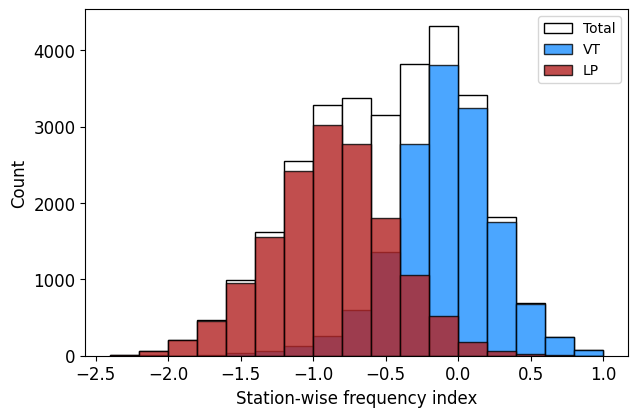

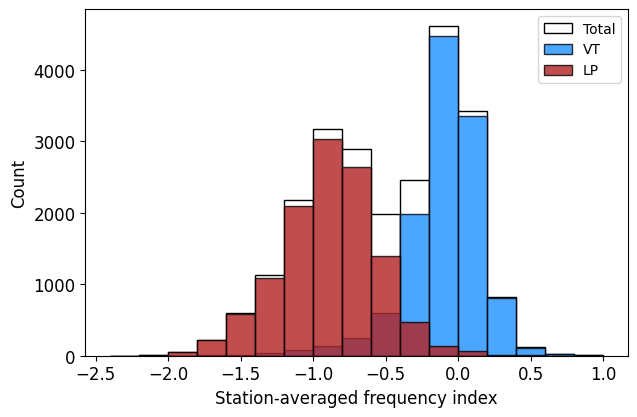

In [13]:
print(f"max {np.max(trace_freq_indices)}")
print(f"min {np.min(trace_freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.4, 1.2, 0.2)
plt.hist(
    trace_freq_indices,
    bins,
    density=False,
    stacked=True,
    color="white",
    edgecolor="black",
    label="Total",
)
plt.hist(
    trace_freq_indices_rg,
    bins,
    density=False,
    edgecolor="black",
    color="dodgerblue",
    alpha=0.8,
    label="VT",
)
plt.hist(
    trace_freq_indices_lp,
    bins,
    density=False,
    edgecolor="black",
    color="firebrick",
    alpha=0.8,
    label="LP",
)
plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-wise frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(root_save_path / "FI_by_traces.jpg", bbox_inches="tight", dpi=600)
# plt.savefig(root_save_path/"FI_by_traces.eps", bbox_inches="tight", dpi=600)

print(f"max {np.max(freq_indices)}")
print(f"min {np.min(freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))


plt.hist(
    freq_indices, bins, density=False, color="white", edgecolor="black", label="Total"
)
plt.hist(
    freq_indices_rg,
    bins,
    density=False,
    color="dodgerblue",
    edgecolor="black",
    alpha=0.8,
    label="VT",
)
plt.hist(
    freq_indices_lp,
    bins,
    density=False,
    color="firebrick",
    edgecolor="black",
    alpha=0.8,
    label="LP",
)

plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-averaged frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(
#     root_save_path / "FI_averaged_over_stations.jpg", bbox_inches="tight", dpi=600
# )

# Evaluation

In [14]:
bins = np.arange(-2.4, 1.2, 0.2)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -2.400000e+00,   -2.200000e+00
  -2.200000e+00,   -2.000000e+00
  -2.000000e+00,   -1.800000e+00
  -1.800000e+00,   -1.600000e+00
  -1.600000e+00,   -1.400000e+00
  -1.400000e+00,   -1.200000e+00
  -1.200000e+00,   -1.000000e+00
  -1.000000e+00,   -8.000000e-01
  -8.000000e-01,   -6.000000e-01
  -6.000000e-01,   -4.000000e-01
  -4.000000e-01,   -2.000000e-01
  -2.000000e-01,    2.220446e-15
   2.220446e-15,    2.000000e-01
   2.000000e-01,    4.000000e-01
   4.000000e-01,    6.000000e-01
   6.000000e-01,    8.000000e-01
   8.000000e-01,    1.000000e+00


(array([408., 355., 323., 362., 358., 332., 317., 326., 337., 268., 288.,
        223., 267., 259., 227., 224., 221., 265., 205., 218., 218., 197.,
        182., 236., 223., 220., 274., 228., 321., 310., 286., 316., 362.,
        416., 428., 441., 497., 516., 535., 502., 607., 616., 607., 590.,
        613., 558., 500., 501., 416., 412.]),
 array([-0.79999948, -0.78200138, -0.76400327, -0.74600517, -0.72800707,
        -0.71000896, -0.69201086, -0.67401276, -0.65601465, -0.63801655,
        -0.62001845, -0.60202034, -0.58402224, -0.56602413, -0.54802603,
        -0.53002793, -0.51202982, -0.49403172, -0.47603362, -0.45803551,
        -0.44003741, -0.42203931, -0.4040412 , -0.3860431 , -0.368045  ,
        -0.35004689, -0.33204879, -0.31405069, -0.29605258, -0.27805448,
        -0.26005638, -0.24205827, -0.22406017, -0.20606206, -0.18806396,
        -0.17006586, -0.15206775, -0.13406965, -0.11607155, -0.09807344,
        -0.08007534, -0.06207724, -0.04407913, -0.02608103, -0.00808293,
 

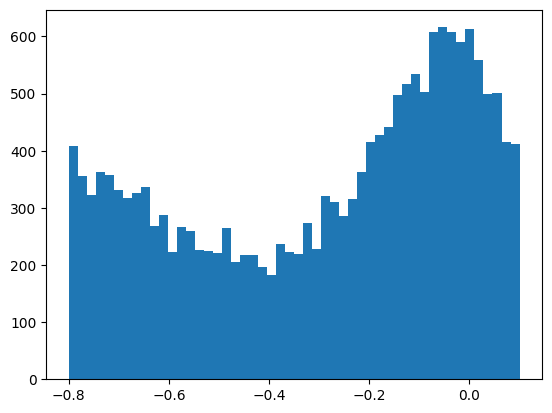

In [15]:
plt.hist(
    data_eq.metadata[
        (data_eq.metadata["source_frequency_index"] > -0.8)
        & (lteq(data_eq.metadata["source_frequency_index"], 0.1))
    ]["source_frequency_index"],
    50,
)

In [16]:
data_eq["trace_name"]

8            bucket8$0,:3,:12192
12           bucket8$1,:3,:12099
16           bucket8$2,:3,:12263
37           bucket8$3,:3,:12257
43           bucket8$4,:3,:12250
                   ...          
315440     bucket81$382,:3,:8900
315458     bucket81$383,:3,:8958
315467    bucket89$758,:3,:11700
315477     bucket81$384,:3,:9499
315485    bucket89$759,:3,:11600
Name: trace_name, Length: 30135, dtype: object

## Predict

In [17]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
FIstrings = []
FIs_midpoint = []
num_seis = {}
for x, y in zip(bins[:-1], bins[1:]):
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )

    sub_dataset = data_eq.filter(mask, inplace=False)

    mask2 = (data_eq_ENZ.metadata["source_frequency_index"] > x) & (
        lteq(data_eq_ENZ.metadata["source_frequency_index"], y)
    )
    sub_dataset_ENZ = data_eq_ENZ.filter(mask2, inplace=False)
    if len(sub_dataset) > 0:
        fi_str = f"({x:.1f},{y:.1f}]"
        # FI_dataset_map[f"{0.5*(x+y):.2f}"]=sub_dataset
        FIstrings.append(fi_str)
        FIs_midpoint.append(0.5 * (x + y))
        print(fi_str, len(sub_dataset))
        num_seis[fi_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_fi = root_save_path / f"{fi_str}"
        try:
            targets_path_fi.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_fi} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_fi,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_fi,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-2.40000000e+00 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00
 -1.60000000e+00 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00
 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01
  2.22044605e-15  2.00000000e-01  4.00000000e-01  6.00000000e-01
  8.00000000e-01  1.00000000e+00]
(-2.4,-2.2] 1


100%|██████████| 1/1 [00:00<00:00, 203.85it/s]


(-2.4,-2.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2200



/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-2.4,-2.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 2142.14it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-2.4,-2.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 2674.94it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2600


No predicted P picks
No predicted S picks
Probability threshold: 0.1500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:320: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:320: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeW

No predicted P picks
(-2.4,-2.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 2465.79it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/minicond

(-2.4,-2.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 1889.33it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.0400



/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/minicon

(-2.4,-2.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 1388.84it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/minicond

(-2.2,-2.0] 11


100%|██████████| 11/11 [00:00<00:00, 461.55it/s]


(-2.2,-2.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 26980.90it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.2,-2.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 28497.43it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.2,-2.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 19895.36it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.2,-2.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 18142.88it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.2,-2.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 16109.41it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.2,-2.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 9076.79it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)


(-2.0,-1.8] 52


100%|██████████| 52/52 [00:00<00:00, 481.01it/s]


(-2.0,-1.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 83341.16it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.0,-1.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 67046.97it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.0,-1.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 58899.22it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.0,-1.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 77838.62it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.0,-1.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 68694.11it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.0,-1.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 81564.63it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.8,-1.6] 255


100%|██████████| 255/255 [00:00<00:00, 516.21it/s]


(-1.8,-1.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 125563.22it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.8,-1.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 138416.92it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.8,-1.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 197115.28it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.8,-1.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 135867.32it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.8,-1.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 147300.31it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.8,-1.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 101062.79it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.6,-1.4] 714


100%|██████████| 714/714 [00:01<00:00, 587.59it/s]


(-1.6,-1.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 155756.65it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.6,-1.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 156816.94it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.6,-1.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 148452.54it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.6,-1.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 147132.41it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.6,-1.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 155449.42it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.6,-1.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 128034.76it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.4,-1.2] 1367


100%|██████████| 1367/1367 [00:01<00:00, 1085.83it/s]


(-1.4,-1.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 163700.60it/s]


Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2200
(-1.4,-1.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 164522.63it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.4,-1.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 252226.53it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.4,-1.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 146004.93it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.4,-1.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 153539.18it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.4,-1.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 162817.37it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.2,-1.0] 2771


100%|██████████| 2771/2771 [00:04<00:00, 680.07it/s]


(-1.2,-1.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 174620.88it/s]


Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2200
(-1.2,-1.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 173933.59it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.2,-1.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 173876.34it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.2,-1.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 259469.48it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.2,-1.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 140951.24it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.2,-1.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 172206.91it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.0,-0.8] 4162


100%|██████████| 4162/4162 [00:05<00:00, 786.36it/s]


(-1.0,-0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 177178.54it/s]


Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2200
(-1.0,-0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 233434.43it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.0,-0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 175027.25it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.0,-0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 171013.28it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.0,-0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 173568.91it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.0,-0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 175746.19it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.8,-0.6] 3698


100%|██████████| 3698/3698 [00:06<00:00, 593.79it/s]


(-0.8,-0.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 142421.32it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.8,-0.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 160423.40it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.8,-0.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 164084.04it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.8,-0.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 159933.76it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.8,-0.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 163979.96it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.8,-0.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 162886.45it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.6,-0.4] 2540


100%|██████████| 2540/2540 [00:05<00:00, 431.53it/s]


(-0.6,-0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 164462.20it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.6,-0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 149069.25it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.6,-0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 163490.51it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.6,-0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 227756.37it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.6,-0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 146676.20it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.6,-0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 167082.78it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.4,-0.2] 3074


100%|██████████| 3074/3074 [00:08<00:00, 350.06it/s]


(-0.4,-0.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 154111.67it/s]


Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2200
(-0.4,-0.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 221214.92it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.4,-0.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 157363.83it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.4,-0.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 139622.40it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.4,-0.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 156280.41it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.4,-0.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 158569.55it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.2,0.0] 5902


100%|██████████| 5902/5902 [00:16<00:00, 362.79it/s]


(-0.2,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 157317.05it/s]


Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2200
(-0.2,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 234544.67it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.2,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 160047.99it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.2,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 153773.60it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.2,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 164843.96it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.2,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 199451.97it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,0.2] 4367


100%|██████████| 4367/4367 [00:06<00:00, 705.90it/s]


(0.0,0.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 177295.02it/s]


Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2200
(0.0,0.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 180325.13it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.0,0.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 175422.12it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.0,0.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 164709.55it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.0,0.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 156052.67it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.0,0.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 154565.92it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.2,0.4] 1058


100%|██████████| 1058/1058 [00:01<00:00, 597.41it/s]


(0.2,0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 236431.01it/s]


Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2200
(0.2,0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 138224.94it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.2,0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 161931.60it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.2,0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 148871.90it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.2,0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 142701.02it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.2,0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 155524.26it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.4,0.6] 137


100%|██████████| 137/137 [00:00<00:00, 309.37it/s]


(0.4,0.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 104552.34it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.4,0.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 105299.55it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.4,0.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 107950.34it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.4,0.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 92160.33it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.4,0.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 108011.21it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.4,0.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 94790.44it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.6,0.8] 21


100%|██████████| 21/21 [00:00<00:00, 464.63it/s]


(0.6,0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 35105.77it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.6,0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 39551.14it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.6,0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 32707.16it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.6,0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 30948.83it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.6,0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 35430.56it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.6,0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 41527.76it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.8,1.0] 4


100%|██████████| 4/4 [00:00<00:00, 413.77it/s]


(0.8,1.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 3686.49it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.8,1.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 7806.99it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.8,1.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 10665.74it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.8,1.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 7814.26it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.8,1.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 6697.49it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.8,1.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 13876.94it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 1:06:48.623204


In [170]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]
avg_snrs=[]
median_snrs=[]
min_snrs=[]
max_snrs=[]
snr_10p=[]
snr_90p=[]
for x, y in zip(bins[:-1], bins[1:]):
    # print(x,y)
    mask=(data_eq.metadata["source_frequency_index"]>x)&(lteq(data_eq.metadata["source_frequency_index"], y))
    group=data_eq.metadata[mask].copy()

    snr_zne=group["trace_snr_db"].apply(str2list)
    snr_zne=snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr=snr_zne.apply(np.nanmean)
    snr=snr[pd.notna(snr)]
    
    avg_snrs.append(np.average(snr.values))
    median_snrs.append(np.median(snr.values))
    min_snrs.append(np.min(snr.values))
    max_snrs.append(np.max(snr.values))
    snr_10p.append(np.percentile(snr.values,10))
    snr_90p.append(np.percentile(snr.values,90))

df_snr=pd.DataFrame(data={"FI_interval":FIstrings,"FI":FIs_midpoint,"mean_snr":avg_snrs,"median_snr":median_snrs,"min_snr":min_snrs,"max_snr":max_snrs,"10_percentile":snr_10p,"90_percentile":snr_90p})
df_snr.to_csv("snr_vs_fi.csv",index=False)

In [18]:
snr

NameError: name 'snr' is not defined

In [171]:
df_snr

,FI_interval,FI,mean_snr,median_snr,min_snr,max_snr,10_percentile,90_percentile
0,"(-2.4,-2.2]",-2.3,11.484437,11.484437,11.484437,11.484437,11.484437,11.484437
1,"(-2.2,-2.0]",-2.1,11.669144,10.641607,2.938699,30.647172,5.101165,15.586016
2,"(-2.0,-1.8]",-1.9,15.197806,13.606696,-0.935811,43.676361,5.844983,29.420531
3,"(-1.8,-1.6]",-1.7,17.208195,17.368786,-2.179872,43.245810,6.020793,26.487642
4,"(-1.6,-1.4]",-1.5,15.432589,15.371816,-3.473964,44.614352,4.898011,25.133796
5,"(-1.4,-1.2]",-1.3,13.372398,13.205215,-5.821095,53.637147,3.714935,22.703156
6,"(-1.2,-1.0]",-1.1,11.586803,11.010119,-5.336976,53.996095,2.744256,20.963717
7,"(-1.0,-0.8]",-0.9,10.601935,9.858986,-12.553719,71.610046,2.624934,18.987568
8,"(-0.8,-0.6]",-0.7,9.812808,8.684368,-13.670948,82.069498,2.003853,18.369375
9,"(-0.6,-0.4]",-0.5,10.425551,8.696951,-27.459271,66.301884,1.369187,22.278459


In [ ]:
with open(root_save_path / "FI_intervals.txt", "w") as FIs_file:
    for x in FIstrings:
        FIs_file.write(f"{x}\n")

# Collect results

In [13]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [14]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_fi.csv",
    "int_pn": "int_pn_fi.csv",
    "vol_pn": "vol_pn_fi.csv",
    "org_eqt": "org_eqt_fi.csv",
    "vol_eqt": "vol_eqt_fi.csv",
    "int_eqt": "int_eqt_fi.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

Write result

In [30]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_fi = []
    s_metrics_vs_fi = []
    for i, (fi_str, fi) in enumerate(zip(FIstrings, FIs_midpoint)):
        # print(i,fi_str,fi)
        tmp_metrics = pd.read_csv(
            root_save_path / f"{fi_str}_pred" / "task0" / exp_name / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["FI"] = fi
        p_tmp_dict["FI_interval"] = fi_str
        p_tmp_dict["n_seis"] = num_seis[fi_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["FI"] = fi
        s_tmp_dict["FI_interval"] = fi_str
        s_tmp_dict["n_seis"] = num_seis[fi_str]

        p_metrics_vs_fi.append(p_tmp_dict)
        s_metrics_vs_fi.append(s_tmp_dict)
    p_metrics_vs_fi = pd.DataFrame(p_metrics_vs_fi)
    p_metrics_vs_fi.to_csv(
        root_save_path / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_fi = pd.DataFrame(s_metrics_vs_fi)
    s_metrics_vs_fi.to_csv(
        root_save_path / f"s.{save_csv_names[exp_name]}", index=False
    )

# Plot figures

In [15]:
nseis_lower_limit = 100

SNR, number of traces

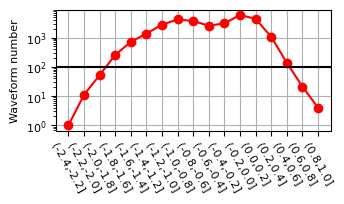

In [36]:
# number of data
exp_name = "vol_eqt"
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")

nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()

cm = 1 / 2.54
fts = 8
fig, axs = plt.subplots(1, 1, figsize=(9 * cm, 4.0 * cm), sharex="all")
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax = axs
ax.semilogy(FIs, nseis, "ro-")
ax.axhline(nseis_lower_limit, color="black")
# ax.set_xlabel("Frequency index groups")
ax.set_ylabel("Waveform number", fontsize=fts)
# ax.set_xticks(FIs)
# ax.set_xticklabels(intervals, rotation=-80)
ax.grid()
ax.tick_params(labelsize=fts)
ax.set_xticks(FIs)
ax.set_xticklabels(intervals, rotation=-60, fontsize=fts)

plt.savefig(root_save_path / "fi_vs_n.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

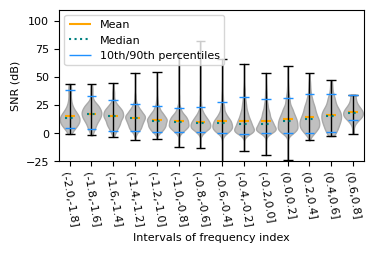

In [32]:
# number of data
exp_name = "vol_eqt"
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")

nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()

cm = 1 / 2.54
fts = 8
fig, axs = plt.subplots(1, 1, figsize=(10 * cm, 5 * cm), sharex="all")
plt.subplots_adjust(wspace=0.05, hspace=0.1)

ax = axs

violin = ax.violinplot(
    dataset=snr_list,
    positions=FIs2,
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

ax.tick_params(labelsize=fts)


# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)
# ax.plot(FIs, mean_snrs, "bo-")
# ax.plot(FIs, median_snrs, "go-")
# ax.axhline(nseis_lower_limit, color="black")
ax.set_xlabel("Intervals of frequency index", fontsize=fts)
ax.set_ylabel("SNR (dB)", fontsize=fts)
ax.set_xticks(FIs)
ax.set_xticklabels(intervals, rotation=-80, fontsize=fts)
ax.legend(loc="upper left", fontsize=fts)
# ax.grid()
ax.set_ylim([-25, 110])
ax.set_xlim([-2, 0.8])
# ax.set_axisbelow(True)
# plt.savefig(root_save_path/"FI_vs_n.jpg", dpi=300, bbox_inches="tight")
plt.savefig(
    root_save_path / "fi_vs_snr.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    root_save_path / "fi_vs_snr.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

-2.4 -2.2
11.484436955577195 11.484436955577195
-2.2 -2.0
2.9386989667304846 30.64717204389671
-2.0 -1.8
-0.9358113052718626 43.67636055754062
-1.8 -1.6
-2.179872120813684 43.24580983232962
-1.6 -1.4
-3.4739644598244 44.6143522736737
-1.4 -1.2
-5.821095319481606 53.63714742009833
-1.2 -1.0
-5.336976444163606 53.996095359615595
-1.0 -0.8
-12.553718766299413 71.61004596144346
-0.8 -0.6
-13.670947515973122 82.06949815888704
-0.6 -0.4
-27.459270561063228 66.30188384874766
-0.4 -0.2
-16.06650890251182 61.76863367488078
-0.2 0.0
-19.874464279252365 53.648774335481185
0.0 0.2
-24.27390331554458 59.59637573008573
0.2 0.4
-6.529966701758215 53.34690017532631
0.4 0.6
-2.7538404306175632 47.10168618434582
0.6 0.8
-0.5815262110464783 34.1711873426291
0.8 1.0
17.46784939984731 23.900952040346706


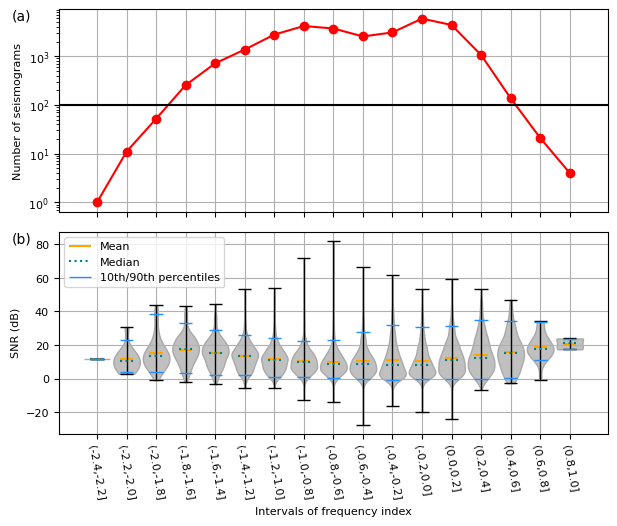

In [133]:
# number of data
exp_name = "vol_eqt"
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")

nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()

cm = 1 / 2.54
fts = 8
fig, axs = plt.subplots(2, 1, figsize=(18 * cm, 14 * cm), sharex="all")
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax = axs[0]
ax.semilogy(FIs, nseis, "ro-")
ax.axhline(nseis_lower_limit, color="black")
# ax.set_xlabel("Frequency index groups")
ax.set_ylabel("Number of seismograms", fontsize=fts)
# ax.set_xticks(FIs)
# ax.set_xticklabels(intervals, rotation=-80)
ax.grid()
ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(a)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)


# SNRs
df_with_enough_data = metrics_vs_fi[metrics_vs_fi["n_seis"] > 0]
intervals2 = df_with_enough_data["FI_interval"].to_numpy()
FIs2 = df_with_enough_data["FI"].to_numpy()


def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


snr_list = []
for fi_str in intervals2:
    x, y = fi_str.lstrip("(").rstrip("]").split(",")
    x = float(x)
    y = float(y)
    print(x, y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]
    print(min(snr), max(snr))
    snr_list.append(snr.values)

ax = axs[1]

violin = ax.violinplot(
    dataset=snr_list,
    positions=FIs2,
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(b)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)

# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)
# ax.plot(FIs, mean_snrs, "bo-")
# ax.plot(FIs, median_snrs, "go-")
# ax.axhline(nseis_lower_limit, color="black")
ax.set_xlabel("Intervals of frequency index", fontsize=fts)
ax.set_ylabel("SNR (dB)", fontsize=fts)
ax.set_xticks(FIs)
ax.set_xticklabels(intervals, rotation=-80, fontsize=fts)
ax.legend(loc="upper left", fontsize=fts)
ax.grid()
# ax.set_axisbelow(True)
# plt.savefig(root_save_path/"FI_vs_n.jpg", dpi=300, bbox_inches="tight")
plt.savefig(
    root_save_path / "fi_vs_n_and_snr.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    root_save_path / "fi_vs_n_and_snr.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

In [33]:
eqt_pred_dirs

['org_eqt', 'int_eqt', 'vol_eqt']

Plot

In [135]:
FIs

array([-1.7, -1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,
        0.5])

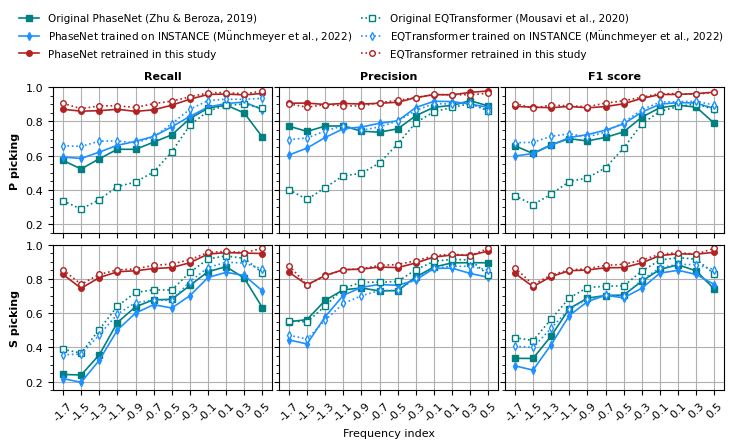

In [156]:
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(
                    FormatStrFormatter("%.1f").format_ticks(FIs),
                    rotation=45,
                )
                # ax.tick_params(which="major", labelrotation=50)
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.2, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)

plt.savefig(
    root_save_path / f"metrics_vs_fi.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    root_save_path / f"metrics_vs_fi.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

In [184]:
len(data_eq)

30135

In [98]:
stead_metadata

,source_id,station_network_code,station_code,trace_frequency_index,source_frequency_index
0,8556349,TA,109C,-0.803163,-0.803163
1,8860238,TA,109C,-1.236236,-1.236236
2,8940123,TA,109C,-0.787506,-0.787506
3,9443190,TA,109C,-1.021429,-1.021429
4,9443449,TA,109C,-1.112612,-1.112612
...,...,...,...,...,...
1030226,uu60206587,WY,YHL,-0.303710,-0.303710
1030227,uu60206632,WY,YHL,-0.254019,-0.254019
1030228,uu60206637,WY,YHL,-0.172723,-0.172723
1030229,uu60206652,WY,YHL,-0.296200,-0.183753


1.5837200202104442
-5.6913336262750605
0.8052362220173376
-2.107490350317512
1.6273361702316074
-4.667948492281088
-1.8 -1.6
-2.179872120813684 43.24580983232962
-1.6 -1.4
-3.4739644598244 44.6143522736737
-1.4 -1.2
-5.821095319481606 53.63714742009833
-1.2 -1.0
-5.336976444163606 53.996095359615595
-1.0 -0.8
-12.553718766299413 71.61004596144346
-0.8 -0.6
-13.670947515973122 82.06949815888704
-0.6 -0.4
-27.459270561063228 66.30188384874766
-0.4 -0.2
-16.06650890251182 61.76863367488078
-0.2 0.0
-19.874464279252365 53.648774335481185
0.0 0.2
-24.27390331554458 59.59637573008573
0.2 0.4
-6.529966701758215 53.34690017532631
0.4 0.6
-2.7538404306175632 47.10168618434582


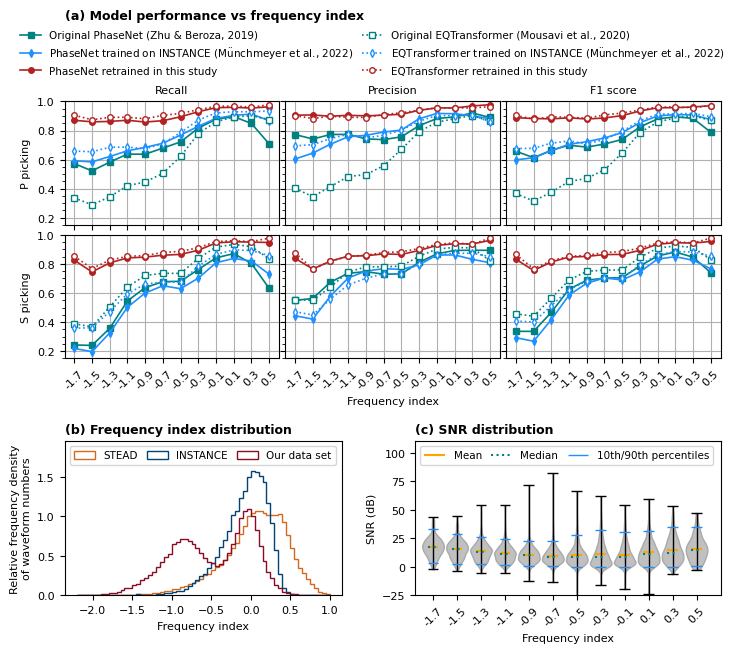

In [96]:
nseis_lower_limit = 100
cm = 1 / 2.54

fig = plt.figure(figsize=(21.5 * cm, 14.5 * cm))
subfigs = fig.subfigures(2, 1, height_ratios=[1.0, 0.6])
axs = subfigs[0].subplots(2, 3, sharex="all", sharey="all")
subfigs[0].subplots_adjust(wspace=0.03, hspace=0.08, bottom=0.16)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(
                    FormatStrFormatter("%.1f").format_ticks(FIs),
                    rotation=45,
                )
                # ax.tick_params(which="major", labelrotation=50)
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts)
axs[1][0].set_ylabel("S picking", fontsize=fts)
axs[0][0].set_title("Recall", fontsize=fts)
axs[0][1].set_title("Precision", fontsize=fts)
axs[0][2].set_title("F1 score", fontsize=fts)
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.25, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.8,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)
axs[0][0].set_title(
    "(a) Model performance vs frequency index",
    y=1.6,
    loc="left",
    weight="bold",
    fontsize=fts + 1,
)

# subfigure 2
axs1 = subfigs[1].subplots(1, 2, width_ratios=[1, 1.1])
subfigs[1].subplots_adjust(wspace=0.25)
subfigs[1].suptitle("")


instance_metadata = pd.read_csv("../data_proc/instance_FI.csv")
stead_metadata = pd.read_csv("../data_proc/stead_FI.csv")
ax = axs1[0]
colors = {"STEAD": "chocolate", "INSTANCE": "#024376", "Our data set": "#880C25"}
up_b = 1.0
lw_b = -2.2
fi_bins = np.arange(lw_b, up_b + 0.01, 0.05)
for i, (meta, label) in enumerate(
    zip(
        [stead_metadata, instance_metadata, data_full_eq.metadata],
        ["STEAD", "INSTANCE", "Our data set"],
    )
):
    # freq_indices = stead_metadata["trace_frequency_index"]
    # event_freq_indices_df = meta.drop_duplicates(
    #     subset="source_id", keep="first", inplace=False
    # )
    freq_indices = meta["source_frequency_index"]
    print(max(freq_indices))
    print(min(freq_indices))
    ax.hist(
        freq_indices,
        fi_bins,
        density=True,
        color="white",
        edgecolor=colors[label],
        histtype="step",
        label=label,
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlabel("Station-averaged frequency index", fontsize=fts)
axs1[0].legend(
    loc="upper left",
    # bbox_to_anchor=(-0.0, 1.0, 1, 0.2),
    # frameon=False,
    fontsize=fts - 0.5,
    ncols=3,
    columnspacing=0.9,
)
axs1[0].set_ylim([0, 1.95])
# SNRs
df_with_enough_data = metrics_vs_fi[metrics_vs_fi["n_seis"] > 0]
intervals2 = df_with_enough_data["FI_interval"].to_numpy()
FIs2 = df_with_enough_data["FI"].to_numpy()


def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


snr_list = []
for fi_str in intervals2:
    x, y = fi_str.lstrip("(").rstrip("]").split(",")
    x = float(x)
    y = float(y)
    print(x, y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]
    print(min(snr), max(snr))
    snr_list.append(snr.values)

violin = axs1[1].violinplot(
    dataset=snr_list,
    positions=FIs2,
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

axs1[1].tick_params(labelsize=fts)
axs1[0].set_xlabel("Frequency index", fontsize=fts)
axs1[1].set_xlabel("Frequency index", fontsize=fts)
axs1[0].set_ylabel("Relative frequency density\nof waveform numbers", fontsize=fts)
axs1[1].set_ylabel("SNR (dB)", fontsize=fts)
axs1[1].set_xticks(FIs)
# axs1[1].set_xticklabels(intervals[2:], rotation=-60, fontsize=fts)
axs1[1].set_xticklabels(
    FormatStrFormatter("%.1f").format_ticks(FIs),
    rotation=45,
)
axs1[1].legend(
    loc="upper left",
    fontsize=fts - 0.5,
    ncols=3,
    columnspacing=0.9,
)
# axs1[1].grid()

axs1[0].set_title(
    "(b) Frequency index distribution",
    loc="left",
    weight="bold",
    fontsize=fts + 1,
)
axs1[1].set_title(
    "(c) SNR distribution",
    loc="left",
    # x=-0.15, y=1.0, ha="left",
    fontsize=fts + 1,
    weight="bold",
)
axs1[1].set_ylim([-25, 110])
axs1[1].set_xlim([-1.85, 0.7])

plt.savefig(
    root_save_path / f"metrics_vs_fi.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    root_save_path / f"metrics_vs_fi.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

In [97]:
freq_indices

0        -0.882456
1        -0.882456
2        -0.821472
3        -0.390263
4        -0.281600
            ...   
315498   -0.581298
315499   -0.581298
315500   -0.581298
315501   -0.581298
315502   -0.581298
Name: source_frequency_index, Length: 303088, dtype: float64

In [188]:
len(dataset)

35120

In [1]:
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(18 * cm, 7 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQT (Mousavi et al., 2020)",
    "int_eqt": r"EQT trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQT retrained in this study",
    "org_pn": "Original PN (Zhu & Beroza, 2019)",
    "int_pn": r"PN trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PN retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([["org_pn", "int_pn"], ["org_eqt", "int_eqt"]]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(2):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(
                    FormatStrFormatter("%.1f").format_ticks(FIs),
                    rotation=60,
                )
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.33, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path / f"org_metrics_vs_fi.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    root_save_path / f"org_metrics_vs_fi.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

NameError: name 'plt' is not defined

Misc

In [16]:
save_csv_names

{'org_pn': 'org_pn_fi.csv',
 'int_pn': 'int_pn_fi.csv',
 'vol_pn': 'vol_pn_fi.csv',
 'org_eqt': 'org_eqt_fi.csv',
 'vol_eqt': 'vol_eqt_fi.csv',
 'int_eqt': 'int_eqt_fi.csv'}

In [32]:
metrics_vs_fi = pd.read_csv(root_save_path / f"p.org_pn_fi.csv")
metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]

In [28]:
metrics_vs_fi["s_F1score"]

,prob_thre,s_TP,s_FP,s_FN,s_precision,s_recall,s_F1score,s_mean,s_median,s_std,...,s_modified_MAD,s_modified_mean2,s_modified_median2,s_modified_std2,s_modified_RMSE2,s_modified_MAE2,s_modified_MAD2,FI,FI_interval,n_seis
0,0.17,1.0,0.0,0.0,1.000000,1.000000,1.000000,-0.170000,-4.12,NaN,...,0.000,-0.170000,-0.170,NaN,0.170000,0.170000,0.000,-2.3,"(-2.4,-2.2]",1
1,0.17,0.0,5.0,11.0,0.000000,0.000000,NaN,0.950000,-0.94,4.350506,...,0.070,-0.636667,-0.640,0.065064,0.638879,0.636667,0.060,-2.1,"(-2.2,-2.0]",11
2,0.17,6.0,22.0,46.0,0.214286,0.115385,0.150000,-0.046786,-0.03,1.195953,...,0.530,-0.378667,-0.620,0.459967,0.583826,0.497333,0.250,-1.9,"(-2.0,-1.8]",52
3,0.17,51.0,80.0,201.0,0.389313,0.202381,0.266319,0.033182,-0.12,2.826289,...,0.675,-0.194805,-0.040,0.426478,0.466337,0.360779,0.280,-1.7,"(-1.8,-1.6]",255
4,0.17,144.0,213.0,554.0,0.403361,0.206304,0.272986,-0.025568,-0.12,3.468058,...,0.615,-0.171729,-0.060,0.433311,0.465157,0.353131,0.255,-1.5,"(-1.6,-1.4]",714
5,0.17,404.0,371.0,923.0,0.521290,0.304446,0.384396,-0.186567,-0.09,3.895239,...,0.450,-0.012783,0.030,0.409884,0.409703,0.293043,0.160,-1.3,"(-1.4,-1.2]",1367
6,0.17,1215.0,800.0,1448.0,0.602978,0.456252,0.519453,-0.110020,-0.04,4.531635,...,0.210,0.082468,0.080,0.305569,0.316395,0.217504,0.110,-1.1,"(-1.2,-1.0]",2771
7,0.17,2175.0,1256.0,1817.0,0.633926,0.544840,0.586016,-0.057001,0.00,5.086103,...,0.170,0.120183,0.090,0.273570,0.298754,0.204086,0.100,-0.9,"(-1.0,-0.8]",4162
8,0.17,2097.0,1223.0,1435.0,0.631627,0.593715,0.612084,-0.043513,0.02,5.331978,...,0.180,0.106772,0.080,0.257262,0.278487,0.190351,0.090,-0.7,"(-0.8,-0.6]",3698
9,0.17,1504.0,816.0,883.0,0.648276,0.630080,0.639048,-0.055937,0.03,5.510142,...,0.160,0.079176,0.060,0.252374,0.264429,0.174072,0.080,-0.5,"(-0.6,-0.4]",2540


In [34]:
np.max(metrics_vs_fi["p_F1score"])

0.8952929875120077

In [24]:
metrics_vs_fi = pd.read_csv(root_save_path / f"s.org_pn_fi.csv")
metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]

In [25]:
np.max(metrics_vs_fi["s_F1score"])

0.8818643857691829

In [40]:
metrics_vs_fi["s_F1score"]

3     0.832000
4     0.754717
5     0.813212
6     0.847201
7     0.851530
8     0.864380
9     0.865340
10    0.893173
11    0.935659
12    0.945680
13    0.943662
14    0.954545
Name: s_F1score, dtype: float64

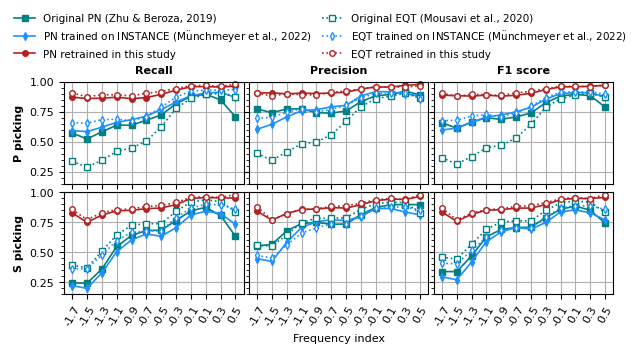

In [171]:
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(18 * cm, 7 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQT (Mousavi et al., 2020)",
    "int_eqt": r"EQT trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQT retrained in this study",
    "org_pn": "Original PN (Zhu & Beroza, 2019)",
    "int_pn": r"PN trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PN retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                    clip_on=False,
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                # ax.set_xticklabels(intervals, rotation=-60)  # , ha="left"
                ax.set_xticklabels(
                    FormatStrFormatter("%.1f").format_ticks(FIs),
                    rotation=60,
                )
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.33, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path / f"metrics_vs_fi_presentation.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    root_save_path / f"metrics_vs_fi_presentation.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

In [13]:
chr(97)

'a'

plot method 2

In [36]:
exp_names_org = ["int_pn", "int_eqt"]
exp_names_retrain = ["vol_pn", "vol_eqt"]

# read results to a dict
p_metrics_dict = {}
s_metrics_dict = {}
metrics_dict = {}
for exp_name in exp_names:
    p_metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")
    p_metrics_vs_fi = p_metrics_vs_fi[
        p_metrics_vs_fi["n_seis"] > nseis_lower_limit
    ]  # only use the results for which the number of data is larger than 100
    p_metrics_dict[exp_name] = p_metrics_vs_fi

    s_metrics_vs_fi = pd.read_csv(root_save_path / f"s.{save_csv_names[exp_name]}")
    s_metrics_vs_fi = s_metrics_vs_fi[
        s_metrics_vs_fi["n_seis"] > nseis_lower_limit
    ]  # only use the results for which the number of data is larger than 100
    s_metrics_dict[exp_name] = s_metrics_vs_fi

    metrics_vs_fi = pd.concat([p_metrics_vs_fi, s_metrics_vs_fi], axis=1)
    metrics_vs_fi = metrics_vs_fi.loc[:, ~metrics_vs_fi.columns.duplicated()].copy()
    metrics_dict[exp_name] = metrics_vs_fi

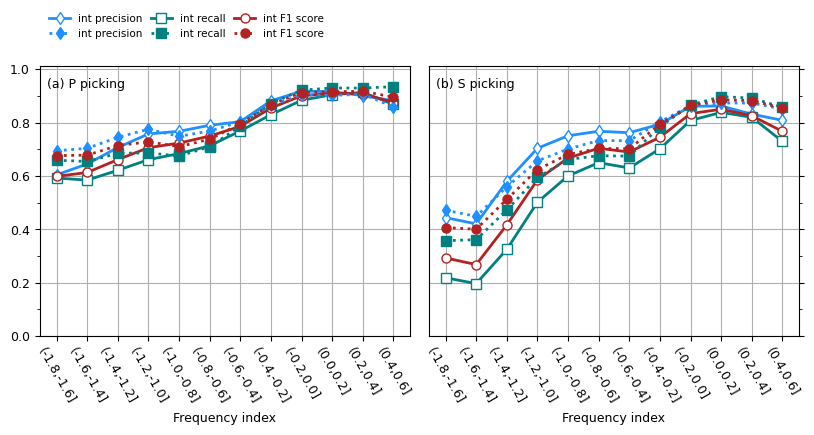

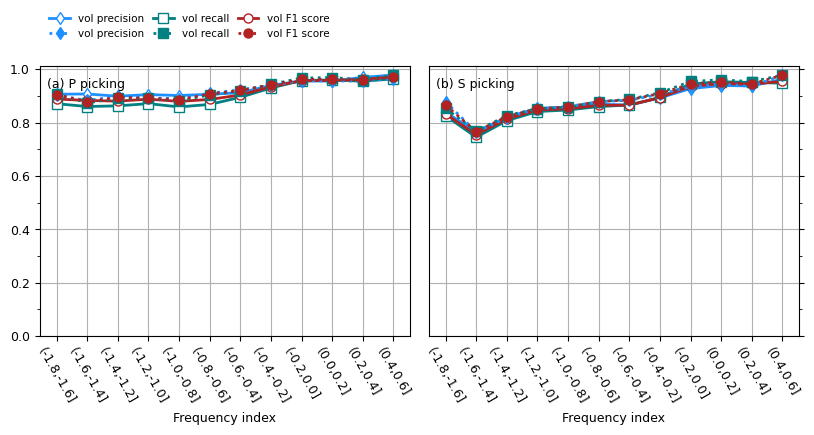

In [37]:
for exp_names_list, fname in zip(
    [exp_names_org, exp_names_retrain], ["metrics_fi_org", "metrics_fi_retrain"]
):
    fig, axs = plt.subplots(1, 2, figsize=(9.8, 3.5), sharex="all", sharey="all")
    plt.subplots_adjust(wspace=0.05)
    ls_dict = {}
    ls_list = []
    mfc_dict = {}
    # solid, dotted, dashed, dashdot
    for exp_name, linestyle, markerfacecolor in zip(
        exp_names_list, ["solid", "dotted"], ["white", None]
    ):
        ls_dict[exp_name] = linestyle
        mfc_dict[exp_name] = markerfacecolor
    #     for exp_name,metrics_vs_fi in metrics_dict.items():
    for exp_name in exp_names_list:
        metrics_vs_fi = metrics_dict[exp_name]
        ### Retrieve different types of metrics
        nseis = metrics_vs_fi["n_seis"].values
        FIs = metrics_vs_fi["FI"].values
        intervals = metrics_vs_fi["FI_interval"].values
        S_pre = metrics_vs_fi["s_precision"].values
        P_pre = metrics_vs_fi["p_precision"].values
        P_recall = metrics_vs_fi["p_recall"].values
        S_recall = metrics_vs_fi["s_recall"].values
        P_F1_score = metrics_vs_fi["p_F1score"].values
        S_F1_score = metrics_vs_fi["s_F1score"].values
        P_mean = metrics_vs_fi["p_mean"].values
        S_mean = metrics_vs_fi["s_mean"].values
        P_out = metrics_vs_fi["p_out"].values
        S_out = metrics_vs_fi["s_out"].values
        P_mae = metrics_vs_fi["p_modified_MAE"].values
        S_mae = metrics_vs_fi["s_modified_MAE"].values
        P_rmse = metrics_vs_fi["p_modified_RMSE"].values
        S_rmse = metrics_vs_fi["s_modified_RMSE"].values

        for ax, phase in zip(axs, ["p", "s"]):
            pre = metrics_vs_fi[f"{phase}_precision"].values
            recall = metrics_vs_fi[f"{phase}_recall"].values
            F1_score = metrics_vs_fi[f"{phase}_F1score"].values
            ax.plot(
                FIs,
                pre,
                color="dodgerblue",
                marker="d",
                markerfacecolor=mfc_dict[exp_name],
                linestyle=ls_dict[exp_name],
                linewidth=2.0,
                markersize=6.5,
                label=f"""{exp_name.split('_')[0]} precision""",
            )
            ax.plot(
                FIs,
                recall,
                color="teal",
                marker="s",
                markerfacecolor=mfc_dict[exp_name],
                linestyle=ls_dict[exp_name],
                linewidth=2.0,
                markersize=6.5,
                label=f"""{exp_name.split('_')[0]} recall""",
            )
            ax.plot(
                FIs,
                F1_score,
                color="firebrick",
                marker="o",
                markerfacecolor=mfc_dict[exp_name],
                linestyle=ls_dict[exp_name],
                linewidth=2.0,
                markersize=6.5,
                label=f"""{exp_name.split('_')[0]} F1 score""",
            )
            ax.set_xlabel("Frequency index", fontsize=fts)
            ax.tick_params(labelsize=fts)
            ax.set_xticks(FIs)
            ax.set_xticklabels(intervals, rotation=-60)
            # ax.yaxis.set_major_locator(MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(MultipleLocator(0.1))
            ax.set_ylim([0.0, 1.01])
            ax.grid(True)
    handles, labels = axs[0].get_legend_handles_labels()
    labels
    order = [0, 3, 1, 4, 2, 5]
    axs[0].legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.00, 1.05, 1, 0.18),
        ncol=3,
        columnspacing=0.8,
        fontsize=fts - 1.5,
        frameon=False,
    )
    axs[1].yaxis.tick_right()

    textx = 0.02
    texty = 0.91
    axs[0].text(
        textx,
        texty,
        "(a) P picking",
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=axs[0].transAxes,
        fontsize=fts,
    )
    axs[1].text(
        textx,
        texty,
        "(b) S picking",
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=axs[1].transAxes,
        fontsize=fts,
    )
#     plt.savefig(root_save_path/f"{fname}.eps", dpi=600, bbox_inches="tight")
#     plt.savefig(root_save_path/f"{fname}.jpg", dpi=600, bbox_inches="tight")

# Test Performances vs SNR

In [64]:
total_snr_zne = data_eq.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [65]:
total_snr_zne2 = data_eq_ENZ.metadata["trace_snr_db"].apply(str2list)
total_snr2 = total_snr_zne2.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [66]:
np.allclose(total_snr2, total_snr, equal_nan=True)

True

In [67]:
pd.isna(total_snr)

8         False
12        False
16        False
37        False
43        False
          ...  
315440    False
315458    False
315467    False
315477    False
315485    False
Name: trace_snr_db, Length: 30135, dtype: bool

In [68]:
data_eq.metadata[pd.isna(total_snr)]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,source_active_volcano_distance_m,trace_chunk,trace_component_order
151317,2341,J041029213039814230961404647,2004-10-29T21:30:39.810000Z,42.516000,140.7745,25.99,0.7,V,lp,NaN,...,NaN,"[nan, nan, nan]",NaN,-0.911895,test,J041029213039814230961404647_YAKUM2.mseed,-0.740282,6150.247594,_japan_vol_lp,ZNE
264120,32561,J090714184258283317891312553,2009-07-14T18:42:58.280000Z,33.298167,131.4255,4.31,0.0,v,natural,NaN,...,NaN,"[nan, nan, nan]",NaN,-0.202758,test,J090714184258283317891312553_OITA2.mseed,-0.184804,1334.715467,_japan_vt,ZNE


In [69]:
def test_fun(x):
    return np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan


# test_fun([np.nan, np.nan, np.nan])
test_fun([0.1, 0.2, 0.7])

0.3333333333333333

(array([1354., 6438., 7483., 6242., 4087., 2139., 1048.,  631.,  373.,
         176.,   66.]),
 array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 11 artists>)

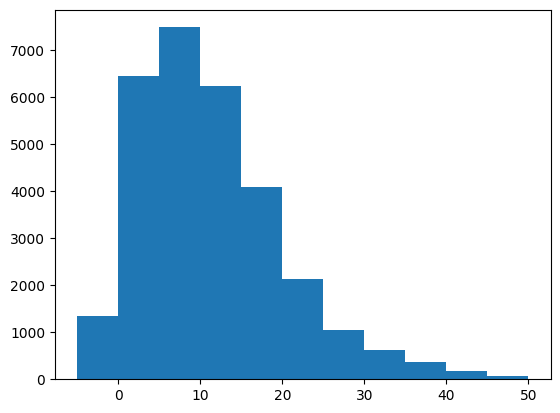

In [70]:
plt.hist(total_snr.values, np.arange(-5, 51, 5))

In [71]:
bins = np.arange(-5, 46, 5)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -5.000000e+00,    0.000000e+00
   0.000000e+00,    5.000000e+00
   5.000000e+00,    1.000000e+01
   1.000000e+01,    1.500000e+01
   1.500000e+01,    2.000000e+01
   2.000000e+01,    2.500000e+01
   2.500000e+01,    3.000000e+01
   3.000000e+01,    3.500000e+01
   3.500000e+01,    4.000000e+01
   4.000000e+01,    4.500000e+01


In [43]:
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))
    print(len(data_eq.metadata[mask]))

1354
6438
7483
6242
4087
2139
1048
631
373
176


In [52]:
root_save_path

PosixPath('.')

In [53]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path / "Test_SNR" / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40 45]
(-5.0,0.0] 1354


100%|██████████| 1354/1354 [00:00<00:00, 1378.84it/s]


Test_SNR/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 136766.39it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 142978.04it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 137182.66it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 310061.56it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 315715.34it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1354/1354 [00:00<00:00, 140214.00it/s]

Number of examples in test: 1354
1354 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 6438


100%|██████████| 6438/6438 [00:04<00:00, 1545.21it/s]


Test_SNR/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 143132.40it/s]


Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 144437.77it/s]

Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 318787.90it/s]

Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 187258.96it/s]

Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 144860.84it/s]

Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6438/6438 [00:00<00:00, 315119.78it/s]

Number of examples in test: 6438
6438 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 7483


100%|██████████| 7483/7483 [00:04<00:00, 1604.34it/s]


Test_SNR/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 144931.04it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 315547.95it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 307880.72it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 140154.13it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 315126.58it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 7483/7483 [00:00<00:00, 312761.97it/s]

Number of examples in test: 7483
7483 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 6242


100%|██████████| 6242/6242 [00:03<00:00, 1857.69it/s]


Test_SNR/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 135740.67it/s]


Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 317570.69it/s]

Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 316556.99it/s]

Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 244406.70it/s]

Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 303968.95it/s]

Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 6242/6242 [00:00<00:00, 138891.16it/s]

Number of examples in test: 6242
6242 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 4087


100%|██████████| 4087/4087 [00:02<00:00, 1392.27it/s]


Test_SNR/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 144945.47it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 297745.83it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 326734.40it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 305983.62it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 315733.53it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4087/4087 [00:00<00:00, 310968.17it/s]

Number of examples in test: 4087
4087 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 2139


100%|██████████| 2139/2139 [00:00<00:00, 2245.65it/s]


Test_SNR/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 306052.27it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 291484.98it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 307710.81it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 302910.94it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 310243.32it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2139/2139 [00:00<00:00, 323896.76it/s]

Number of examples in test: 2139
2139 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 1048


100%|██████████| 1048/1048 [00:00<00:00, 2248.06it/s]


Test_SNR/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 240329.72it/s]


Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 133939.62it/s]

Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 266240.50it/s]

Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 298029.06it/s]

Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 307236.36it/s]

Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1048/1048 [00:00<00:00, 302209.05it/s]

Number of examples in test: 1048
1048 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 631


100%|██████████| 631/631 [00:00<00:00, 2134.73it/s]


Test_SNR/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 304662.81it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 308678.08it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 103597.52it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 267902.20it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 278648.75it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 631/631 [00:00<00:00, 127185.63it/s]

Number of examples in test: 631
631 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 373


100%|██████████| 373/373 [00:00<00:00, 2152.78it/s]


Test_SNR/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 155067.44it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 300860.65it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 238124.11it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 283009.30it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 137174.52it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 373/373 [00:00<00:00, 267981.40it/s]

Number of examples in test: 373
373 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(40.0,45.0] 176


100%|██████████| 176/176 [00:00<00:00, 1209.40it/s]


Test_SNR/(40.0,45.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 116068.79it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(40.0,45.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 96812.79it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(40.0,45.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 258020.80it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(40.0,45.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 121274.44it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(40.0,45.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 274831.54it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(40.0,45.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 176/176 [00:00<00:00, 274320.89it/s]

Number of examples in test: 176
176 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:18:28.568230


In [9]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [10]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [11]:
root_save_path_snr = root_save_path / "Test_SNR"

In [59]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

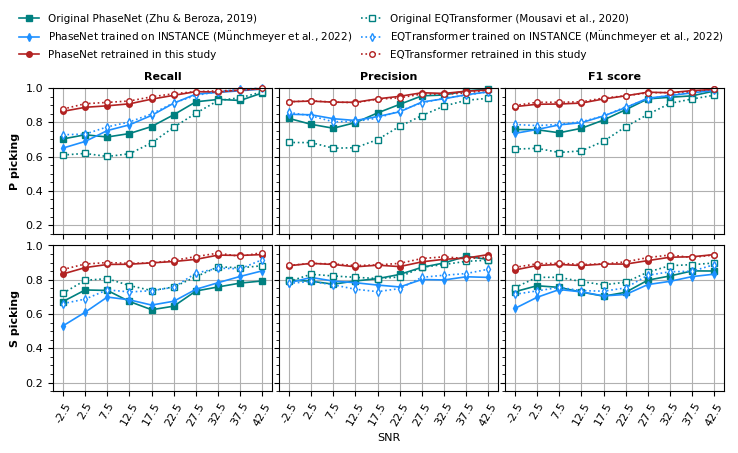

In [117]:
nseis_lower_limit = 100
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_snr = pd.read_csv(
                root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_snr = metrics_vs_snr[
                metrics_vs_snr["n_seis"] > nseis_lower_limit
            ]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                SNRs = metrics_vs_snr["SNR"].values
                intervals = (
                    metrics_vs_snr["SNR_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_snr[f"{phase}_{metric}"]
                ax.plot(
                    SNRs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                    clip_on=False,
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(SNRs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(SNRs, rotation=60)  # , ha="left"
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.2, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("SNR", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

LP

In [84]:
total_snr_zne = data_eq_lp.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

total_snr_zne2 = data_eq_ENZ_lp.metadata["trace_snr_db"].apply(str2list)
total_snr2 = total_snr_zne2.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [85]:
np.allclose(total_snr2, total_snr, equal_nan=True)

True

(array([ 410., 2834., 4347., 3812., 2237.,  897.,  287.,  140.,   68.]),
 array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <BarContainer object of 9 artists>)

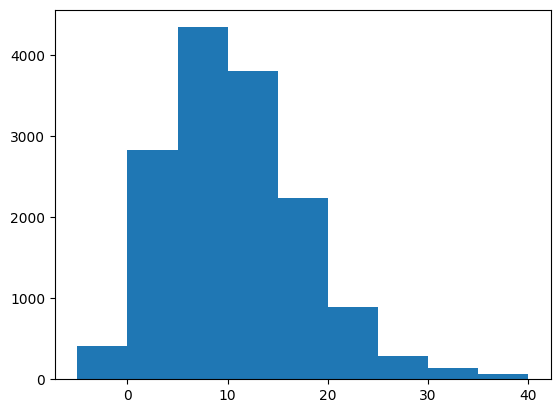

In [81]:
plt.hist(total_snr.values, np.arange(-5, 41, 5))

In [82]:
bins = np.arange(-5, 41, 5)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -5.000000e+00,    0.000000e+00
   0.000000e+00,    5.000000e+00
   5.000000e+00,    1.000000e+01
   1.000000e+01,    1.500000e+01
   1.500000e+01,    2.000000e+01
   2.000000e+01,    2.500000e+01
   2.500000e+01,    3.000000e+01
   3.000000e+01,    3.500000e+01
   3.500000e+01,    4.000000e+01


In [86]:
root_save_path_snr = root_save_path / "Test_SNR_lp"

In [87]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq_lp.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq_lp.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ_lp.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path_snr / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40]
(-5.0,0.0] 410


100%|██████████| 410/410 [00:00<00:00, 1389.49it/s]


Test_SNR_lp/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 104241.05it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 297262.69it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 145623.22it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 270515.12it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 118950.31it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 410/410 [00:00<00:00, 284195.11it/s]

Number of examples in test: 410
410 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 2834


100%|██████████| 2834/2834 [00:01<00:00, 1844.58it/s]


Test_SNR_lp/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 302813.92it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 312313.65it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 305569.60it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 296100.48it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 137448.20it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2834/2834 [00:00<00:00, 302075.16it/s]

Number of examples in test: 2834
2834 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 4347


100%|██████████| 4347/4347 [00:02<00:00, 1620.03it/s]


Test_SNR_lp/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 315449.05it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 316001.24it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 300833.89it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 316253.37it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 319781.11it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4347/4347 [00:00<00:00, 144160.03it/s]

Number of examples in test: 4347
4347 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 3812


100%|██████████| 3812/3812 [00:02<00:00, 1644.19it/s]


Test_SNR_lp/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 328971.79it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 312920.77it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 149835.88it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 307764.76it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 312132.73it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3812/3812 [00:00<00:00, 320087.42it/s]

Number of examples in test: 3812
3812 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 2237


100%|██████████| 2237/2237 [00:01<00:00, 1396.46it/s]


Test_SNR_lp/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 137073.16it/s]


Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR_lp/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 141111.70it/s]

Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 325481.60it/s]

Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 143947.75it/s]

Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 145539.77it/s]

Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2237/2237 [00:00<00:00, 113577.75it/s]

Number of examples in test: 2237
2237 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 897


100%|██████████| 897/897 [00:00<00:00, 2185.37it/s]


Test_SNR_lp/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 317412.53it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 135994.60it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 135339.07it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 130422.25it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 256987.07it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 897/897 [00:00<00:00, 307527.44it/s]

Number of examples in test: 897
897 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 287


100%|██████████| 287/287 [00:00<00:00, 2075.83it/s]


Test_SNR_lp/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 279685.23it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 294031.57it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 120957.12it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 122358.74it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 282375.15it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 287/287 [00:00<00:00, 124073.93it/s]

Number of examples in test: 287
287 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 140


100%|██████████| 140/140 [00:00<00:00, 2325.58it/s]


Test_SNR_lp/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 283398.92it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 203395.41it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 133546.18it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 244667.73it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 103235.33it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 140/140 [00:00<00:00, 147984.52it/s]

Number of examples in test: 140
140 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 68


100%|██████████| 68/68 [00:00<00:00, 819.70it/s]


Test_SNR_lp/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 57409.96it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 221782.79it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 226000.53it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 220071.51it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 229086.48it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 68/68 [00:00<00:00, 107142.25it/s]

Number of examples in test: 68
68 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:15:00.374160


In [88]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [92]:
root_save_path_snr = root_save_path / "Test_SNR_lp"
root_save_path_snr

PosixPath('Test_SNR_lp')

In [93]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

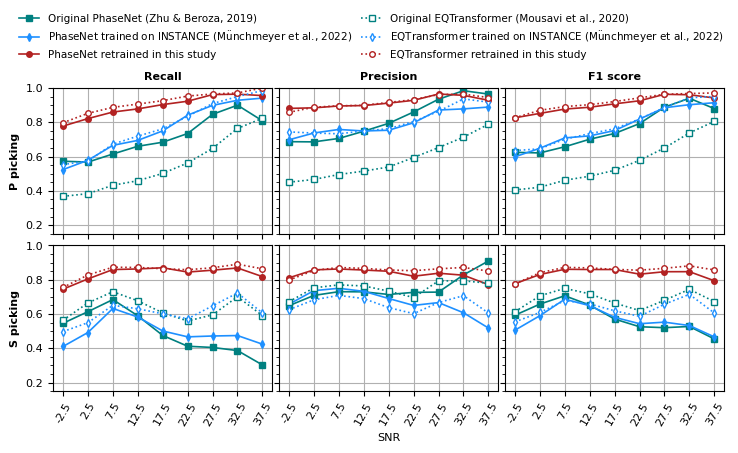

In [94]:
nseis_lower_limit = 50
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_snr = pd.read_csv(
                root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_snr = metrics_vs_snr[
                metrics_vs_snr["n_seis"] > nseis_lower_limit
            ]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                SNRs = metrics_vs_snr["SNR"].values
                intervals = (
                    metrics_vs_snr["SNR_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_snr[f"{phase}_{metric}"]
                ax.plot(
                    SNRs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(SNRs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(SNRs, rotation=60)  # , ha="left"
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.2, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("SNR", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr_lp.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr_lp.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

VT

In [95]:
total_snr_zne = data_eq_rg.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

total_snr_zne2 = data_eq_ENZ_rg.metadata["trace_snr_db"].apply(str2list)
total_snr2 = total_snr_zne2.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [96]:
np.allclose(total_snr2, total_snr, equal_nan=True)

True

(array([ 944., 3604., 3136., 2430., 1850., 1242.,  761.,  491.,  305.,
         157.]),
 array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <BarContainer object of 10 artists>)

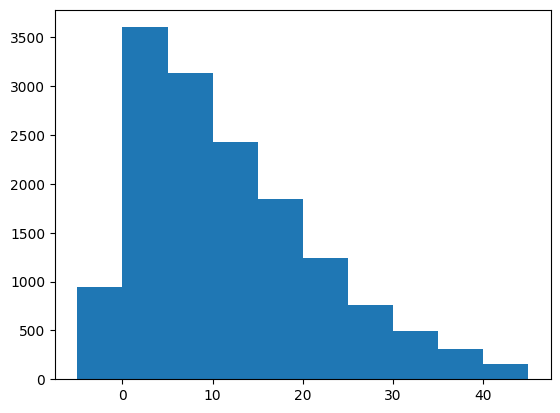

In [102]:
plt.hist(total_snr.values, np.arange(-5, 46, 5))

In [103]:
bins = np.arange(-5, 46, 5)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -5.000000e+00,    0.000000e+00
   0.000000e+00,    5.000000e+00
   5.000000e+00,    1.000000e+01
   1.000000e+01,    1.500000e+01
   1.500000e+01,    2.000000e+01
   2.000000e+01,    2.500000e+01
   2.500000e+01,    3.000000e+01
   3.000000e+01,    3.500000e+01
   3.500000e+01,    4.000000e+01
   4.000000e+01,    4.500000e+01


In [105]:
root_save_path_snr = root_save_path / "Test_SNR_vt"
root_save_path_snr

PosixPath('Test_SNR_vt')

In [106]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq_rg.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq_rg.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ_rg.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path_snr / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40 45]
(-5.0,0.0] 944


100%|██████████| 944/944 [00:00<00:00, 2089.78it/s]


Test_SNR_vt/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 309160.85it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 124447.54it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 303869.76it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 133967.96it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 141919.89it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 944/944 [00:00<00:00, 291498.42it/s]

Number of examples in test: 944
944 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 3604


100%|██████████| 3604/3604 [00:02<00:00, 1512.02it/s]


Test_SNR_vt/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 313115.39it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 312888.55it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 141158.79it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 309195.76it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 142919.14it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3604/3604 [00:00<00:00, 316710.42it/s]

Number of examples in test: 3604
3604 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 3136


100%|██████████| 3136/3136 [00:02<00:00, 1381.54it/s]


Test_SNR_vt/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 135916.69it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 138123.23it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 311454.28it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 119612.77it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 198946.34it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3136/3136 [00:00<00:00, 312616.45it/s]

Number of examples in test: 3136
3136 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 2430


100%|██████████| 2430/2430 [00:01<00:00, 1332.95it/s]


Test_SNR_vt/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 138035.93it/s]


Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR_vt/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 155356.43it/s]

Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 298793.90it/s]

Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 296758.15it/s]

Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 136348.13it/s]

Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2430/2430 [00:00<00:00, 144068.96it/s]

Number of examples in test: 2430
2430 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 1850


100%|██████████| 1850/1850 [00:01<00:00, 1711.41it/s]


Test_SNR_vt/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 299732.01it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 301795.43it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 197773.93it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 136619.87it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 295767.58it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1850/1850 [00:00<00:00, 280114.88it/s]

Number of examples in test: 1850
1850 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 1242


100%|██████████| 1242/1242 [00:00<00:00, 1552.78it/s]


Test_SNR_vt/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 305424.81it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 304674.56it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 245213.97it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 288285.86it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 144170.86it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1242/1242 [00:00<00:00, 126139.90it/s]

Number of examples in test: 1242
1242 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 761


100%|██████████| 761/761 [00:00<00:00, 1314.14it/s]


Test_SNR_vt/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 190843.97it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 307471.86it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 320114.87it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 277529.38it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 130867.79it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 761/761 [00:00<00:00, 133105.31it/s]

Number of examples in test: 761
761 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 491


100%|██████████| 491/491 [00:00<00:00, 1038.30it/s]


Test_SNR_vt/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 171032.58it/s]


Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR_vt/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 303567.70it/s]

Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 297989.19it/s]

Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 287184.95it/s]

Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 277547.61it/s]

Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 491/491 [00:00<00:00, 280419.83it/s]

Number of examples in test: 491
491 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 305


100%|██████████| 305/305 [00:00<00:00, 2221.98it/s]


Test_SNR_vt/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 300861.41it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 146017.89it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 233356.94it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 127403.92it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 147960.06it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 305/305 [00:00<00:00, 121303.12it/s]

Number of examples in test: 305
305 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(40.0,45.0] 157


100%|██████████| 157/157 [00:00<00:00, 2349.41it/s]


Test_SNR_vt/(40.0,45.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 277616.24it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(40.0,45.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 254642.59it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(40.0,45.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 119968.25it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(40.0,45.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 251338.06it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(40.0,45.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 110265.53it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(40.0,45.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 157/157 [00:00<00:00, 252882.38it/s]

Number of examples in test: 157
157 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:19:21.996319


In [104]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [110]:
root_save_path_snr = root_save_path / "Test_SNR_vt"

In [112]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

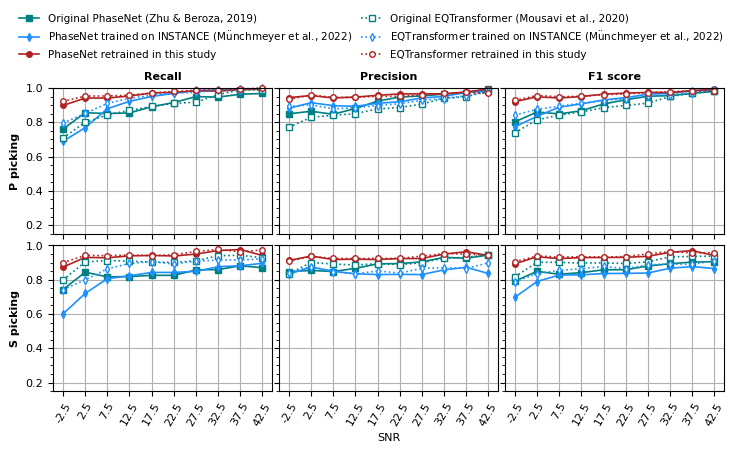

In [114]:
nseis_lower_limit = 100
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_snr = pd.read_csv(
                root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_snr = metrics_vs_snr[
                metrics_vs_snr["n_seis"] > nseis_lower_limit
            ]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                SNRs = metrics_vs_snr["SNR"].values
                intervals = (
                    metrics_vs_snr["SNR_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_snr[f"{phase}_{metric}"]
                ax.plot(
                    SNRs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                    clip_on=False,
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(SNRs)
                # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.set_xticklabels(SNRs, rotation=60)  # , ha="left"
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.2, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("SNR", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr_vt.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    root_save_path_snr / f"metrics_vs_snr_vt.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

put two figures together

In [105]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [100]:
root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"

PosixPath('Test_SNR_lp/p.org_pn_fi.csv')

In [101]:
exp_name

'org_pn'

In [103]:
save_csv_names

{'org_pn': 'org_pn_fi.csv',
 'int_pn': 'int_pn_fi.csv',
 'vol_pn': 'vol_pn_fi.csv',
 'org_eqt': 'org_eqt_fi.csv',
 'vol_eqt': 'vol_eqt_fi.csv',
 'int_eqt': 'int_eqt_fi.csv'}

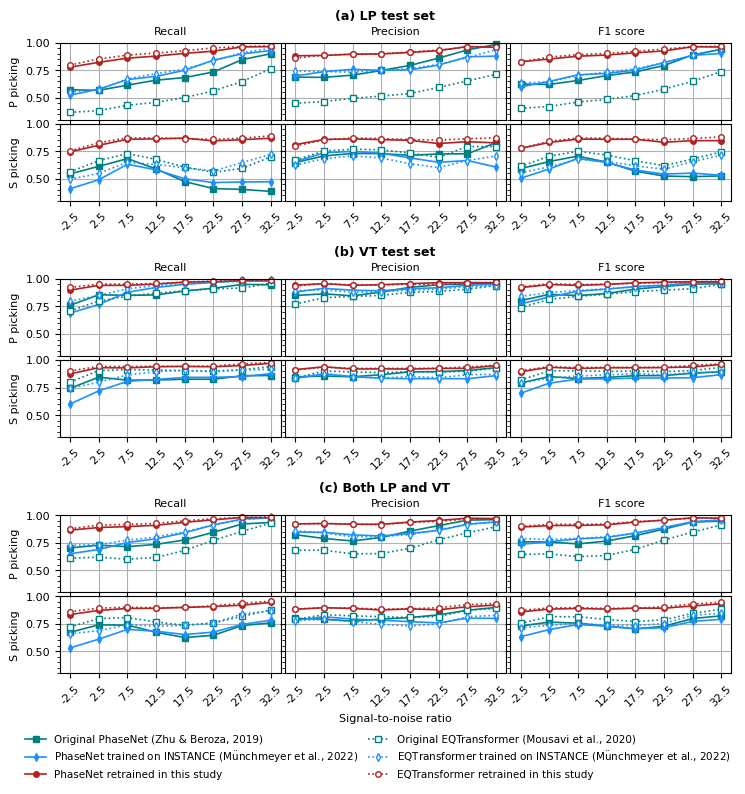

In [108]:
nseis_lower_limit = 50
cm = 1 / 2.54

fig = plt.figure(figsize=(22 * cm, 18 * cm))
subfigs = fig.subfigures(3, 1, height_ratios=[1.0, 1.0, 1.0])

# fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 8 * cm), sharex="all", sharey="all")

# plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]

root_save_path_snr_list = [
    root_save_path / "Test_SNR_lp",
    root_save_path / "Test_SNR_vt",
    root_save_path / "Test_SNR",
]
titles = ["(a) LP test set", "(b) VT test set", "(c) Both LP and VT"]
for i_fig in range(3):
    root_save_path_snr = root_save_path_snr_list[i_fig]
    axs = subfigs[i_fig].subplots(2, 3, sharex="all", sharey="all")
    # axs[0][1].set_title(
    #     titles[i_fig],
    #     y=1.2,
    #     x=0.5,
    #     # loc="center",
    #     weight="bold",
    #     fontsize=fts + 1,
    # )
    subfigs[i_fig].suptitle(
        titles[i_fig], x=0.5, y=1.02, fontsize=fts + 1, weight="bold"
    )
    subfigs[i_fig].subplots_adjust(wspace=0.02, hspace=0.05, bottom=0.21)
    for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
        markerfacecolor = markerfacecolors[i_net]
        markeredgecolor = markeredgecolors[i_net]
        linestyle = linestyles[i_net]

        for i in range(3):
            exp_name = pred_dirs[i]
            color = colors[i]
            marker = markers[i]

            for j, phase in enumerate(["p", "s"]):
                metrics_vs_snr = pd.read_csv(
                    root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"
                )
                metrics_vs_snr = metrics_vs_snr[
                    (metrics_vs_snr["n_seis"] > nseis_lower_limit)
                    & (
                        metrics_vs_snr["SNR"] < 35
                    )  # to make lp and vt have the seme x axis
                ]
                for k, metric in enumerate(["recall", "precision", "F1score"]):
                    SNRs = metrics_vs_snr["SNR"].values
                    intervals = (
                        metrics_vs_snr["SNR_interval"]
                        .apply(lambda x: x.replace(",", ", "))
                        .values
                    )
                    ax = axs[j][k]
                    metric_value = metrics_vs_snr[f"{phase}_{metric}"]
                    ax.plot(
                        SNRs,
                        metric_value,
                        color=color,
                        linewidth=lw,
                        linestyle=linestyle,
                        marker=marker,
                        markeredgecolor=markeredgecolor,
                        markerfacecolor=markerfacecolor,
                        markersize=ms,
                        label=labels[exp_name],
                        clip_on=False,
                    )
                    ax.tick_params(labelsize=fts)
                    ax.set_xticks(SNRs)
                    # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                    ax.set_xticklabels(SNRs, rotation=45)  # , ha="left"
                    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                    ax.set_ylim([0.3, 1])
                    ax.grid(True)
    axs[0][0].set_ylabel("P picking", fontsize=fts)
    axs[1][0].set_ylabel("S picking", fontsize=fts)
    axs[0][0].set_title("Recall", fontsize=fts)
    axs[0][1].set_title("Precision", fontsize=fts)
    axs[0][2].set_title("F1 score", fontsize=fts)
    if i_fig == 2:
        axs[-1][0].legend(
            loc="lower left",
            bbox_to_anchor=(-0.2, -1.5, 1, 0.5),
            frameon=False,
            fontsize=fts - 0.5,
            ncols=2,
            columnspacing=0.9,
        )
        axs[1][1].set_xlabel("Signal-to-noise ratio", fontsize=fts)

plt.savefig(
    f"metrics_vs_snr.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    f"metrics_vs_snr.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)